In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from torchvision.datasets import MNIST
from torchvision import transforms

mean, std = 0.1307, 0.3081

train_dataset = MNIST('../data/MNIST', train=True, download=True,
                             transform=transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Normalize((mean,), (std,))
                             ]))
test_dataset = MNIST('../data/MNIST', train=False, download=True,
                            transform=transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((mean,), (std,))
                            ]))
n_classes = 10

In [3]:
import torch
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable

from trainer import fit
import numpy as np
cuda = torch.cuda.is_available()

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

mnist_classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']

def plot_embeddings(embeddings, targets, xlim=None, ylim=None):
    plt.figure(figsize=(10,10))
    for i in range(10):
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[i])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(mnist_classes)

def extract_embeddings(dataloader, model):
    with torch.no_grad():
        model.eval()
        embeddings = np.zeros((len(dataloader.dataset), 2))
        labels = np.zeros(len(dataloader.dataset))
        k = 0
        for images, target in dataloader:
            if cuda:
                images = images.cuda()
            embeddings[k:k+len(images)] = model.get_embedding(images).data.cpu().numpy()
            labels[k:k+len(images)] = target.numpy()
            k += len(images)
    return embeddings, labels

In [4]:
# Set up data loaders
batch_size = 256
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet, ClassificationNet
from metrics import AccumulatedAccuracyMetric

embedding_net = EmbeddingNet()
model = ClassificationNet(embedding_net, n_classes=n_classes)
if cuda:
    model.cuda()
loss_fn = torch.nn.NLLLoss()
lr = 1e-2
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 50

In [5]:
fit(train_loader, test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, metrics=[AccumulatedAccuracyMetric()])

Train: [0/60000 (0%)]	Loss: 2.384671	Accuracy: 9.765625
Train: [12800/60000 (21%)]	Loss: 2.507760	Accuracy: 19.5389093137
Train: [25600/60000 (43%)]	Loss: 1.165965	Accuracy: 36.6723391089
Train: [38400/60000 (64%)]	Loss: 0.612343	Accuracy: 52.5972682119
Train: [51200/60000 (85%)]	Loss: 0.373950	Accuracy: 62.5077736318
Epoch: 1/20. Train set: Average loss: 1.0452	Accuracy: 66.9116666667
Epoch: 1/20. Validation set: Average loss: 0.2735	Accuracy: 94.52
Train: [0/60000 (0%)]	Loss: 0.301963	Accuracy: 92.96875
Train: [12800/60000 (21%)]	Loss: 0.259604	Accuracy: 94.8759191176
Train: [25600/60000 (43%)]	Loss: 0.211426	Accuracy: 95.3357054455
Train: [38400/60000 (64%)]	Loss: 0.179648	Accuracy: 95.6979511589
Train: [51200/60000 (85%)]	Loss: 0.174379	Accuracy: 95.9771455224
Epoch: 2/20. Train set: Average loss: 0.2024	Accuracy: 96.0783333333
Epoch: 2/20. Validation set: Average loss: 0.1699	Accuracy: 96.74
Train: [0/60000 (0%)]	Loss: 0.177497	Accuracy: 95.3125
Train: [12800/60000 (21%)]	Loss: 0.

Train: [25600/60000 (43%)]	Loss: 0.005199	Accuracy: 99.895575495
Train: [38400/60000 (64%)]	Loss: 0.004088	Accuracy: 99.9016970199
Train: [51200/60000 (85%)]	Loss: 0.005917	Accuracy: 99.8931125622
Epoch: 19/20. Train set: Average loss: 0.0052	Accuracy: 99.895
Epoch: 19/20. Validation set: Average loss: 0.1342	Accuracy: 99.17
Train: [0/60000 (0%)]	Loss: 0.011978	Accuracy: 99.609375
Train: [12800/60000 (21%)]	Loss: 0.004534	Accuracy: 99.9234068627
Train: [25600/60000 (43%)]	Loss: 0.004531	Accuracy: 99.9187809406
Train: [38400/60000 (64%)]	Loss: 0.005181	Accuracy: 99.9068708609
Train: [51200/60000 (85%)]	Loss: 0.005365	Accuracy: 99.902829602
Epoch: 20/20. Train set: Average loss: 0.0050	Accuracy: 99.905
Epoch: 20/20. Validation set: Average loss: 0.1365	Accuracy: 99.18


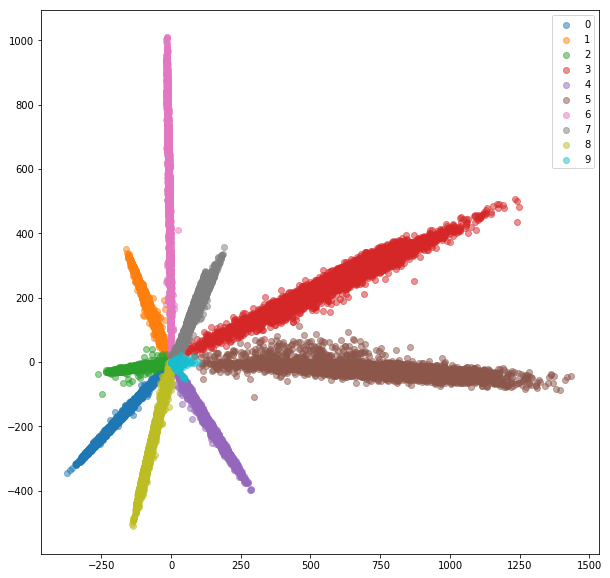

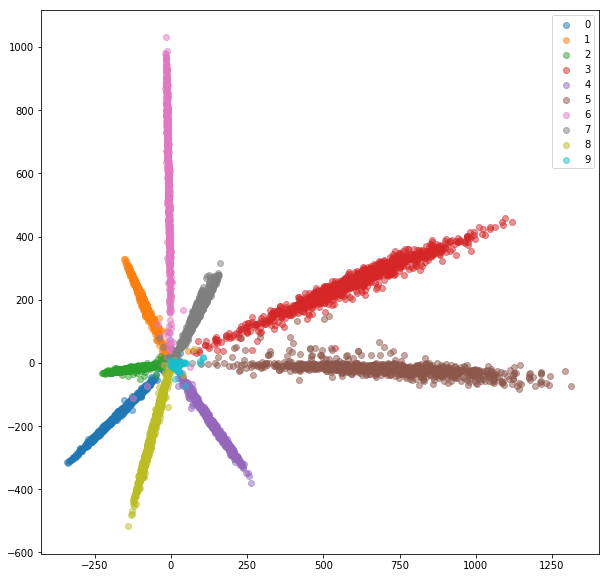

In [6]:
train_embeddings_baseline, train_labels_baseline = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_baseline, train_labels_baseline)
val_embeddings_baseline, val_labels_baseline = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_baseline, val_labels_baseline)

In [7]:
# Set up data loaders
from datasets import SiameseMNIST

siamese_train_dataset = SiameseMNIST(train_dataset) # Returns pairs of images and target same/different
siamese_test_dataset = SiameseMNIST(test_dataset)
batch_size = 128
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
siamese_train_loader = torch.utils.data.DataLoader(siamese_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
siamese_test_loader = torch.utils.data.DataLoader(siamese_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet, SiameseNet
from losses import ContrastiveLoss

margin = 1.
embedding_net = EmbeddingNet()
model = SiameseNet(embedding_net)
if cuda:
    model.cuda()
loss_fn = ContrastiveLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 100

In [8]:
fit(siamese_train_loader, siamese_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

Train: [0/60000 (0%)]	Loss: 0.227033
Train: [12800/60000 (21%)]	Loss: 0.065764
Train: [25600/60000 (43%)]	Loss: 0.039546
Train: [38400/60000 (64%)]	Loss: 0.030424
Train: [51200/60000 (85%)]	Loss: 0.024430
Epoch: 1/20. Train set: Average loss: 0.0376
Epoch: 1/20. Validation set: Average loss: 0.0188
Train: [0/60000 (0%)]	Loss: 0.018157
Train: [12800/60000 (21%)]	Loss: 0.017251
Train: [25600/60000 (43%)]	Loss: 0.016934
Train: [38400/60000 (64%)]	Loss: 0.013403
Train: [51200/60000 (85%)]	Loss: 0.011404
Epoch: 2/20. Train set: Average loss: 0.0143
Epoch: 2/20. Validation set: Average loss: 0.0132
Train: [0/60000 (0%)]	Loss: 0.004413
Train: [12800/60000 (21%)]	Loss: 0.011235
Train: [25600/60000 (43%)]	Loss: 0.008717
Train: [38400/60000 (64%)]	Loss: 0.010102
Train: [51200/60000 (85%)]	Loss: 0.009031
Epoch: 3/20. Train set: Average loss: 0.0093
Epoch: 3/20. Validation set: Average loss: 0.0094
Train: [0/60000 (0%)]	Loss: 0.006509
Train: [12800/60000 (21%)]	Loss: 0.006995
Train: [25600/60000 (

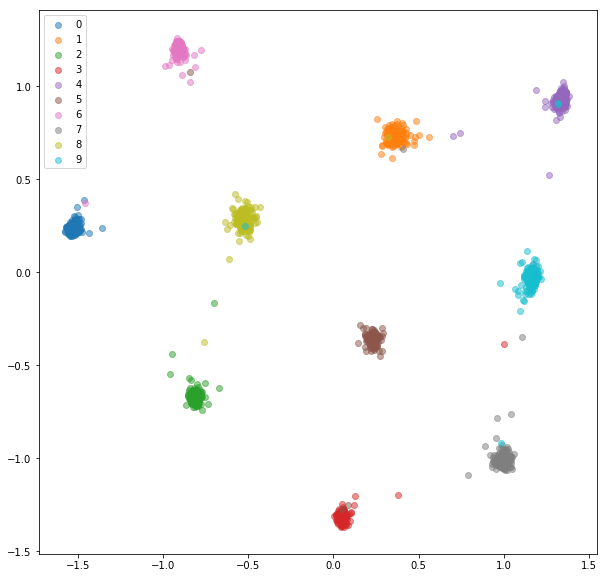

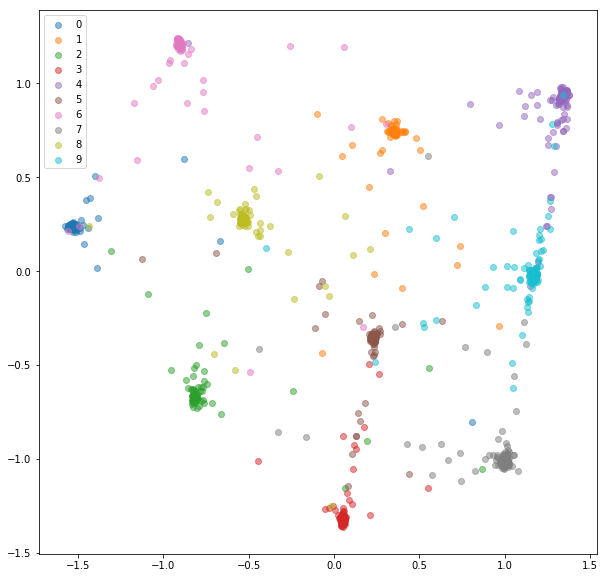

In [9]:
train_embeddings_cl, train_labels_cl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_cl, train_labels_cl)
val_embeddings_cl, val_labels_cl = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_cl, val_labels_cl)

In [10]:
# Set up data loaders
from datasets import TripletMNIST

triplet_train_dataset = TripletMNIST(train_dataset) # Returns triplets of images
triplet_test_dataset = TripletMNIST(test_dataset)
batch_size = 128
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
triplet_train_loader = torch.utils.data.DataLoader(triplet_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
triplet_test_loader = torch.utils.data.DataLoader(triplet_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet, TripletNet
from losses import TripletLoss

margin = 1.
embedding_net = EmbeddingNet()
model = TripletNet(embedding_net)
if cuda:
    model.cuda()
loss_fn = TripletLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 100

In [11]:
fit(triplet_train_loader, triplet_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

Train: [0/60000 (0%)]	Loss: 0.999796
Train: [12800/60000 (21%)]	Loss: 0.317366
Train: [25600/60000 (43%)]	Loss: 0.148854
Train: [38400/60000 (64%)]	Loss: 0.101223
Train: [51200/60000 (85%)]	Loss: 0.080853
Epoch: 1/20. Train set: Average loss: 0.1496
Epoch: 1/20. Validation set: Average loss: 0.0669
Train: [0/60000 (0%)]	Loss: 0.054546
Train: [12800/60000 (21%)]	Loss: 0.058292
Train: [25600/60000 (43%)]	Loss: 0.050593
Train: [38400/60000 (64%)]	Loss: 0.052183
Train: [51200/60000 (85%)]	Loss: 0.043369
Epoch: 2/20. Train set: Average loss: 0.0492
Epoch: 2/20. Validation set: Average loss: 0.0445
Train: [0/60000 (0%)]	Loss: 0.046879
Train: [12800/60000 (21%)]	Loss: 0.036157
Train: [25600/60000 (43%)]	Loss: 0.032027
Train: [38400/60000 (64%)]	Loss: 0.036879
Train: [51200/60000 (85%)]	Loss: 0.032158
Epoch: 3/20. Train set: Average loss: 0.0340
Epoch: 3/20. Validation set: Average loss: 0.0346
Train: [0/60000 (0%)]	Loss: 0.042179
Train: [12800/60000 (21%)]	Loss: 0.027840
Train: [25600/60000 (

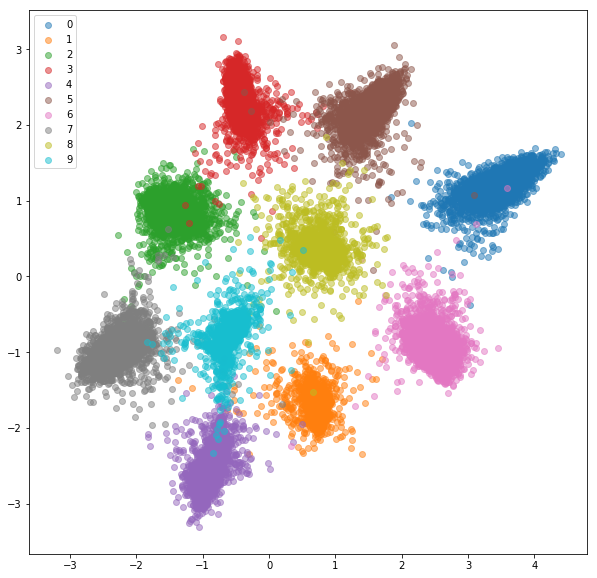

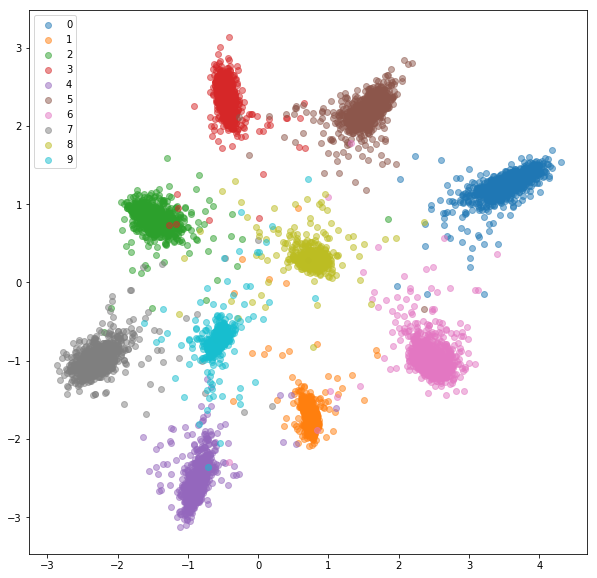

In [12]:
train_embeddings_tl, train_labels_tl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_tl, train_labels_tl)
val_embeddings_tl, val_labels_tl = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_tl, val_labels_tl)